## Load data

In [1]:
import numpy as np
from keras.utils.np_utils import to_categorical
import keras

Using Theano backend.


In [2]:
%pylab inline
%load_ext autoreload
%autoreload 2

Populating the interactive namespace from numpy and matplotlib


In [3]:
datapath = '/media/sf_VBox_Shared/timeseries/EEGs_Guinea-Bissau_np/'#'/media/windows-share/EEGs_Guinea-Bissau_np/'

In [4]:
condition = '_10seconds_closed.npy'
X_train = np.load(datapath+'X_train'+condition)
y_train = np.load(datapath+'y_train'+condition)
X_val = np.load(datapath+'X_valid'+condition)
y_val = np.load(datapath+'y_valid'+condition)
X_test = np.load(datapath+'X_test'+condition)
y_test = np.load(datapath+'y_test'+condition)

In [5]:
classlabels = list(set(y_train))
mapclasses = {classlabels[i] : i for i in range(len(classlabels))}
print(mapclasses)

{'Epilepsy': 0, 'Control': 1}


In [6]:
y_train = np.array([mapclasses[c] for c in y_train], dtype='int')
y_val = np.array([mapclasses[c] for c in y_test], dtype='int')
y_test = np.array([mapclasses[c] for c in y_test], dtype='int')
y_train_binary = to_categorical(y_train)
y_val_binary = to_categorical(y_val)
y_test_binary = to_categorical(y_test)

In [7]:
y_val_binary

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [39]:
print(X_train.shape)

(108, 1280, 14)


In [8]:
num_classes = y_train_binary.shape[1]
print(num_classes)

2


## Generate models

In [9]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Convolution1D, Flatten, MaxPooling1D
from keras.optimizers import Adam

In [10]:
import sys
import os
import numpy as np
sys.path.insert(0, os.path.abspath('..'))

from mcfly import modelgen, find_architecture

In [50]:
np.random.seed = 321

In [51]:
%%time
models = modelgen.generate_models(X_train.shape,
                                  num_classes,
                                  number_of_models = 10,
                                  model_type = 'CNN',
                                  min_layers=2,
                                  max_layers=6,
                                 low_lr=2, high_lr=8)

CPU times: user 1.07 s, sys: 140 ms, total: 1.21 s
Wall time: 1.33 s


In [52]:
%%time
for model, params, model_types in models:
    print(params)
    model.summary()

{'filters': array([36, 59]), 'learning_rate': 2.152269317631185e-08, 'regularization_rate': 0.0010697884591542956, 'fc_hidden_nodes': 88}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_35 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_35[0][0]
____________________________________________________________________________________________________
convolution1d_149 (Convolution1D)(None, 1280, 36)      1548        batchnormalization_35[0][0]      
____________________________________________________________________________________________________
activation_217 (Activation)      (None, 1280, 36)      0           convolution1d_149[0][0]          
____________________________________________________________________________________________________
convolution1d_150 (Convolution1D)(None, 1280, 59)     

## Compare models

In [53]:
%%time
histories, val_accuracies, val_losses = find_architecture.train_models_on_samples(X_train, y_train_binary,
                                                                                 X_val, y_val_binary,
                                                                                 models,nr_epochs=10,
                                                                                  subsize_set=200,
                                                                                  verbose=True)

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 3s - loss: 0.8557 - acc: 0.5648 - val_loss: 2.1987 - val_acc: 0.5500
Epoch 2/10
108/108 [==============================] - 2s - loss: 0.8447 - acc: 0.5833 - val_loss: 0.9445 - val_acc: 0.5500
Epoch 3/10
108/108 [==============================] - 2s - loss: 0.8483 - acc: 0.5833 - val_loss: 0.8225 - val_acc: 0.5500
Epoch 4/10
108/108 [==============================] - 2s - loss: 0.8463 - acc: 0.5833 - val_loss: 0.8099 - val_acc: 0.5500
Epoch 5/10
108/108 [==============================] - 2s - loss: 0.8514 - acc: 0.6019 - val_loss: 0.8097 - val_acc: 0.5500
Epoch 6/10
108/108 [==============================] - 2s - loss: 0.8578 - acc: 0.5926 - val_loss: 0.8137 - val_acc: 0.6000
Epoch 7/10
108/108 [==============================] - 2s - loss: 0.8469 - acc: 0.6019 - val_loss: 0.8100 - val_acc: 0.5500
Epoch 8/10
108/108 [==============================] - 2s - loss: 0.8529 - acc: 0.5741 - val_lo

In [ ]:
np.random.seed = 123
np.rand

CPU times: user 2.9 s, sys: 0 ns, total: 2.9 s
Wall time: 3.12 s


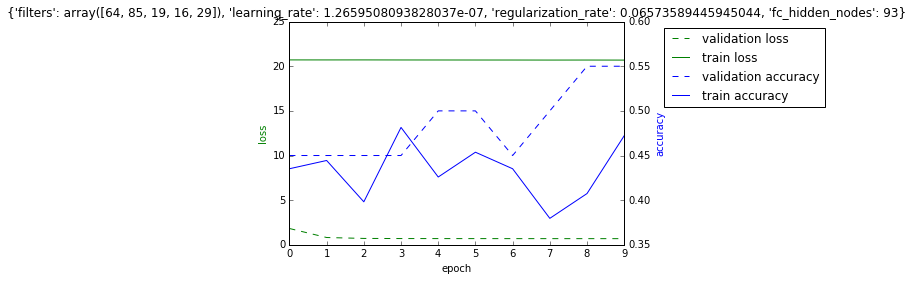

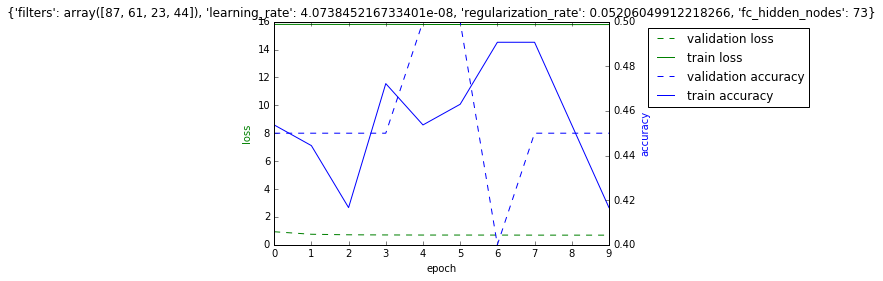

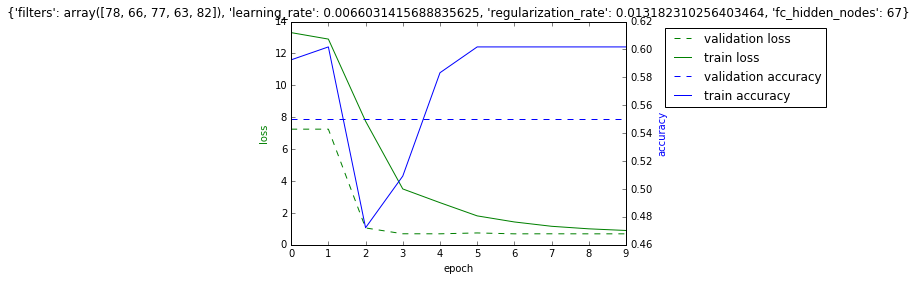

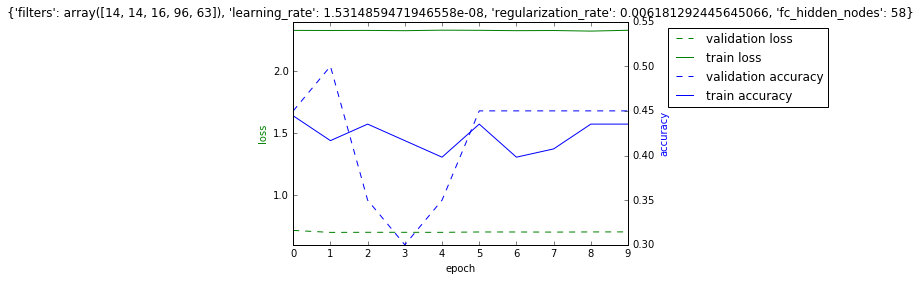

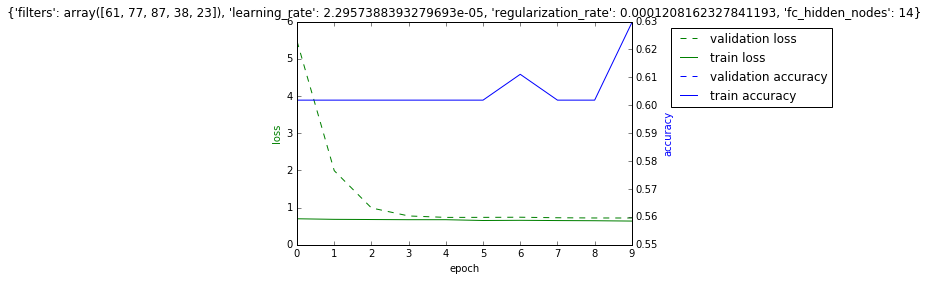

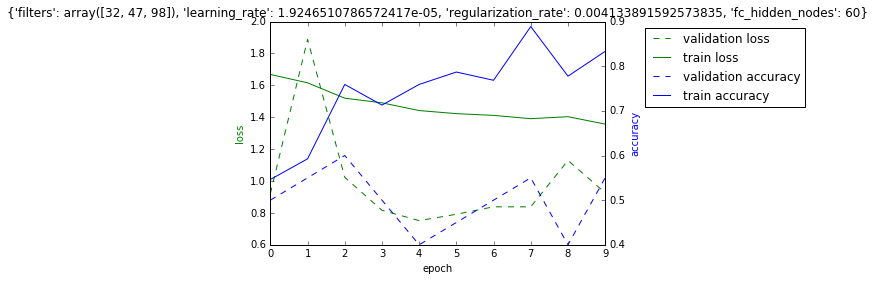

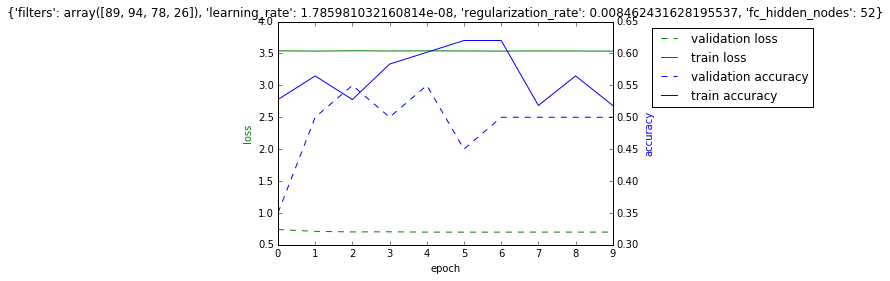

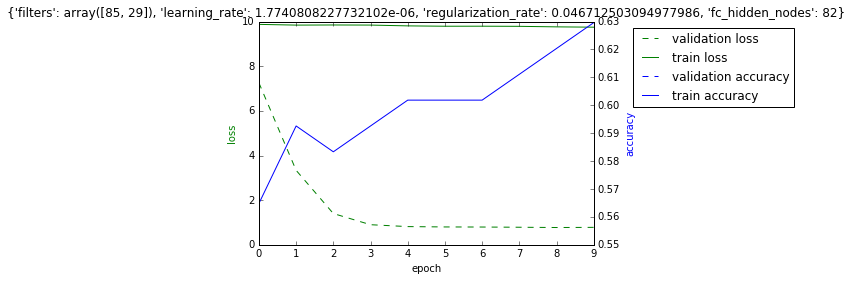

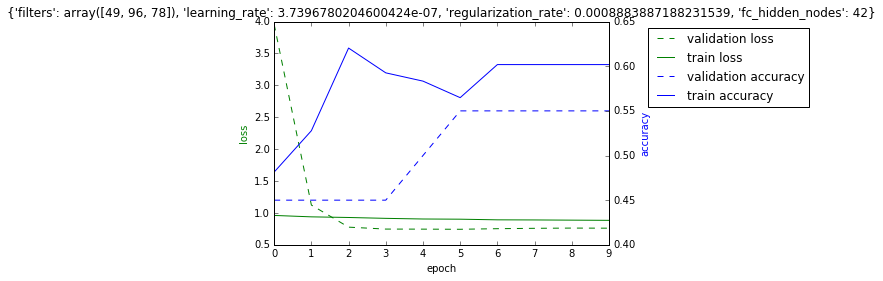

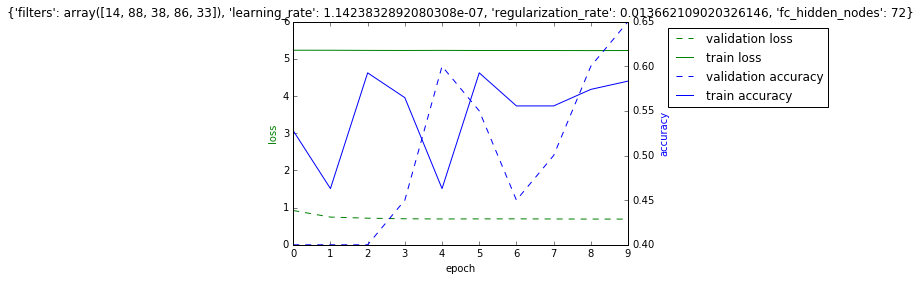

In [48]:
%%time
for i in range(len(models)):
    name = str(models[i][1])
    find_architecture.plotTrainingProcess(histories[i], name)

In [49]:
#%%time
import pandas as pd
results = pd.DataFrame({'model':[str(params) for model, params, model_types in models],
                       'train_acc': [history.history['acc'][-1] for history in histories],
                       'train_loss': [history.history['loss'][-1] for history in histories],
                       'val_acc': [history.history['val_acc'][-1] for history in histories],
                       'val_loss': [history.history['val_loss'][-1] for history in histories]
                       })
results

,model,train_acc,train_loss,val_acc,val_loss
0,"{'filters': array([64, 85, 19, 16, 29]), 'lear...",0.472222,20.688981,0.55,0.688986
1,"{'filters': array([87, 61, 23, 44]), 'learning...",0.416667,15.789132,0.45,0.691832
2,"{'filters': array([78, 66, 77, 63, 82]), 'lear...",0.601852,0.897968,0.55,0.688208
3,"{'filters': array([14, 14, 16, 96, 63]), 'lear...",0.435185,2.330022,0.45,0.704093
4,"{'filters': array([61, 77, 87, 38, 23]), 'lear...",0.629630,0.637980,0.55,0.720359
5,"{'filters': array([32, 47, 98]), 'learning_rat...",0.833333,1.357014,0.55,0.926384
6,"{'filters': array([89, 94, 78, 26]), 'learning...",0.518519,3.537137,0.50,0.699198
7,"{'filters': array([85, 29]), 'learning_rate': ...",0.629630,9.749951,0.55,0.781576
8,"{'filters': array([49, 96, 78]), 'learning_rat...",0.601852,0.883636,0.55,0.760521
9,"{'filters': array([14, 88, 38, 86, 33]), 'lear...",0.583333,5.222821,0.65,0.691211


In [52]:
models

[(<keras.models.Sequential at 0x7f7f014c74a8>,
  {'fc_hidden_nodes': 67,
   'filters': array([53, 38, 68]),
   'learning_rate': 6.266192650778009e-06,
   'regularization_rate': 0.000641226389722406},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f01467cc0>,
  {'fc_hidden_nodes': 86,
   'filters': array([71]),
   'learning_rate': 0.00011354609464633791,
   'regularization_rate': 0.000148307727535519},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f013d78d0>,
  {'fc_hidden_nodes': 45,
   'filters': array([52, 45]),
   'learning_rate': 4.051588205407558e-08,
   'regularization_rate': 0.0001372609193256655},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f0135e128>,
  {'fc_hidden_nodes': 50,
   'filters': array([77]),
   'learning_rate': 1.548308288145927e-05,
   'regularization_rate': 0.00011014276088560432},
  'CNN'),
 (<keras.models.Sequential at 0x7f7f012d73c8>,
  {'fc_hidden_nodes': 77,
   'filters': array([30, 73, 65]),
   'learning_rate': 2.2241454272714142e-08,
   'regularization_rate'

## Train the best model for real

In [34]:
#best_model_index = np.argmax(val_accuracies)
#best_model_index = np.argmax(val_losses)
best_model_index = 1

In [27]:
import theano
theano.config.mode

'Mode'

In [35]:
best_model, best_params, best_model_types = models[best_model_index]
print(best_model_index, best_model_types, best_params)

1 CNN {'filters': array([62, 46, 13, 82, 21, 10, 60, 82, 84]), 'learning_rate': 0.00843196626913817, 'regularization_rate': 0.000523339694792114, 'fc_hidden_nodes': 77}


In [36]:
best_model_copy = modelgen.generate_CNN_model(X_train.shape, num_classes, best_params['filters'], best_params['fc_hidden_nodes'],
                       best_params['learning_rate'], best_params['regularization_rate'])
print(best_model_index, best_model_types, best_params)

1 CNN {'filters': array([62, 46, 13, 82, 21, 10, 60, 82, 84]), 'learning_rate': 0.00843196626913817, 'regularization_rate': 0.000523339694792114, 'fc_hidden_nodes': 77}


In [41]:
nr_epochs = 10
datasize = X_train.shape[0]#1000
history = best_model_copy.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=20)

Train on 108 samples, validate on 20 samples
Epoch 1/10
108/108 [==============================] - 10s - loss: 10.5013 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/10
108/108 [==============================] - 9s - loss: 10.3382 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/10
108/108 [==============================] - 10s - loss: 10.2106 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/10
108/108 [==============================] - 8s - loss: 10.1108 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 5/10
108/108 [==============================] - 8s - loss: 10.0321 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 6/10
108/108 [==============================] - 8s - loss: 9.9697 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 7/10
108/108 [==============================] - 9s - loss: 9.9199 - acc: 0.3981 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 8/10
108/108 [==============================] - 9s - loss: 9.8800 - acc: 0.3981 -

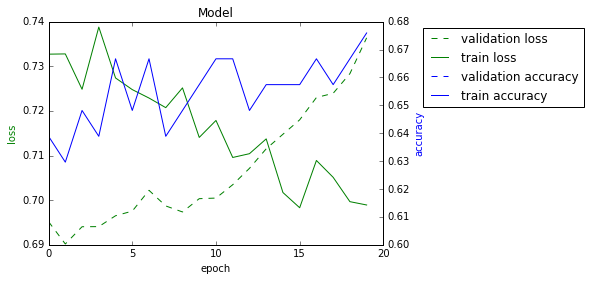

In [19]:
find_architecture.plotTrainingProcess(history)

## Inspect model predictions

In [55]:
datasize = X_val.shape[0]
best_model_copy.predict_proba(X_val[:datasize,:,:],batch_size=1)

20/20 [==============================] - 1s     


array([[  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00],
       [  2.82884394e-36,   1.00000000e+00]])

In [56]:
best_model_copy.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_24 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_24[0][0]
____________________________________________________________________________________________________
convolution1d_99 (Convolution1D) (None, 1280, 62)      2666        batchnormalization_24[0][0]      
____________________________________________________________________________________________________
activation_145 (Activation)      (None, 1280, 62)      0           convolution1d_99[0][0]           
____________________________________________________________________________________________________
convolution1d_100 (Convolution1D)(None, 1280, 46)      8602        activation_145[0][0]             
___________________________________________________________________________________________

In [57]:
from keras import backend as K

# with a Sequential model
get_dens_layer_output = K.function([best_model_copy.layers[0].input, K.learning_phase()],
                                  [best_model_copy.layers[0].output])
layer_output = get_dens_layer_output([X_val, 0])[0]

In [77]:
layer_output.shape

(20, 1280, 14)

In [82]:
layer_output.mean(axis=(0,1))

array([ 0.01279549, -0.00897324, -0.04084716, -0.07526646,  0.01399508,
       -0.06247653, -0.01134645,  0.00290158,  0.02717606, -0.04093175,
       -0.05238502,  0.05782415,  0.0397981 , -0.06900693], dtype=float32)

In [80]:
layer = best_model.layers[0]
for w in layer.get_weights():
    print(w.shape)

(14,)
(14,)
(14,)
(14,)


## See if we can overfit on a small train set

In [118]:
params = models[0][1]
print(params)
small_model = modelgen.generate_CNN_model(X_train.shape, num_classes, params['filters'], params['fc_hidden_nodes'],
                                  0.01, #params['learning_rate'], 
                                        regularization_rate=0)
small_model.summary()

{'learning_rate': 6.266192650778009e-06, 'fc_hidden_nodes': 67, 'regularization_rate': 0.000641226389722406, 'filters': array([53, 38, 68])}
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
batchnormalization_34 (BatchNorma(None, 1280, 14)      28          batchnormalization_input_34[0][0]
____________________________________________________________________________________________________
convolution1d_76 (Convolution1D) (None, 1280, 53)      2279        batchnormalization_34[0][0]      
____________________________________________________________________________________________________
activation_142 (Activation)      (None, 1280, 53)      0           convolution1d_76[0][0]           
____________________________________________________________________________________________________
convolution1d_77 (Convolution1D) (None, 1280, 38)  

In [114]:
small_model.evaluate(X_val, y_val_binary)

20/20 [==============================] - 0s


[8.8649530410766602, 0.44999998807907104]

In [119]:
nr_epochs = 100
datasize = 20
history = small_model.fit(X_train[:datasize,:,:], y_train_binary[:datasize,:],
              nb_epoch=nr_epochs, validation_data=(X_val, y_val_binary), batch_size=10)

Train on 20 samples, validate on 20 samples
Epoch 1/100
20/20 [==============================] - 0s - loss: 1.1408 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 2/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 3/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 4/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 5/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 6/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 7/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.8650 - val_acc: 0.4500
Epoch 8/100
20/20 [==============================] - 0s - loss: 2.4177 - acc: 0.8500 - val_loss: 8.865

KeyboardInterrupt: 

## Test on Testset

In [ ]:
score_test = best_model.evaluate(X_test, y_test_binary, verbose=False)
print('Score of best model: ' + str(score_test))

In [ ]:
best_model.get_config()[0]